In [1]:
import numpy as np
from numba import jit, njit
import matplotlib.pyplot as plt

### pre-segmentation

In [2]:
a = 2
T = 2600
lmin, lmax = 5, 1500


In [3]:
@njit
def pre_seg_indices(a,T,lmin,lmax):

    n_expected = round((lmax-lmin)*T/(a**2)) + 1
    intervals = np.zeros((n_expected,2), np.uint64)
    cnt = 0
    for i in range(0,T,a):
        for j in range(i+a,T,a):
            if (j-i >= lmin) and (j-i<=lmax):  
                intervals[cnt] = (i,j)
                cnt += 1
        j = T
        if (j-i >= lmin) and (j-i<=lmax):  
            intervals[cnt] = (i,j)
            cnt += 1
            
    return intervals[:cnt]

In [4]:
%timeit pre_seg_indices(a,T,lmin,lmax)

3.11 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
pre_seg_indices(a,T,lmin,lmax)

array([[   0,    6],
       [   0,    8],
       [   0,   10],
       ...,
       [2592, 2598],
       [2592, 2600],
       [2594, 2600]], dtype=uint64)

### fixed-dim embedding

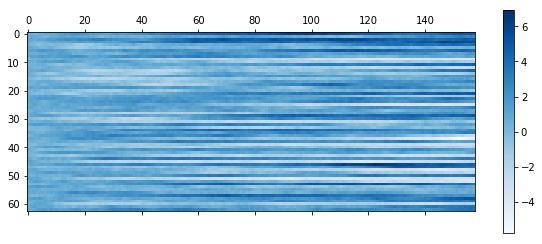

In [6]:
# for an arbitrary n0 x d vector
d = 63
n0 = 158
X = np.zeros((n0,d))
X[0] = np.random.rand(d)
for i in range(1,n0):
    X[i] = X[i-1] + 0.8*(np.random.rand(d)-0.5)
plt.matshow(X.T,cmap='Blues')
plt.colorbar()

In [7]:
# target params
# F : transformation matrix
# n : fixed #output frames
# r, s: constant weights, hyperparams

n = 100
r, s = 0.07, 0.1


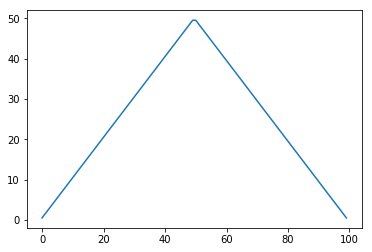

In [8]:
from scipy.signal import triang

def g_i(n):
    return triang(n) * (n/2)

x = np.arange(0,n)
g = g_i(n)
plt.plot(x,g[x])

In [9]:
# gaussian kernel
@jit
def fgaussian(n0, mu, sigma):

    x = np.arange(0,n0)
    kernel = (1/sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sigma)**2)
    
    return kernel / np.sum(kernel)

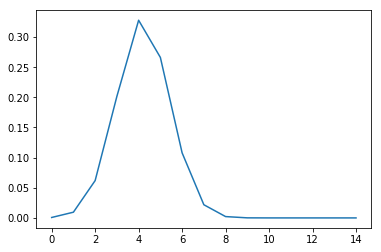

In [10]:
plt.plot(fgaussian(15, 4.2, 1.2))

In [11]:
%timeit fgaussian(15, 4.2, 1.2)

892 ns ± 12.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


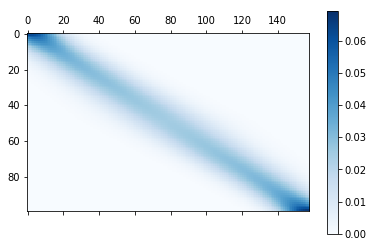

In [11]:
# get transformation matrix
@jit
def gauss_transformation_mat(n, n0, g, r, s):
    F = np.zeros((n,n0))

    for i in range(n):
        mu = (i*n0)/n
        sigma = r*n0 + s*g[i]
        F[i] = fgaussian(n0, mu, sigma)

    return F

F = gauss_transformation_mat(n, n0, g, r, s)
plt.matshow(F,cmap='Blues')
plt.colorbar()

In [61]:
%timeit gauss_transformation_mat(n, n0, g, r, s)

346 µs ± 2.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


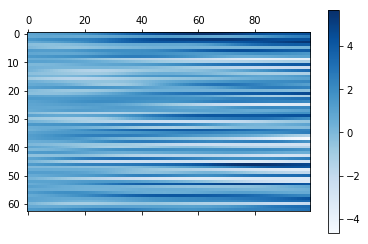

In [12]:
# do interpolation

X_emb = np.matmul(F,X)
plt.matshow(X_emb.T,cmap='Blues')
plt.colorbar()

####  embedding main func


In [13]:
def embed(X, n, r, s):
    
    n0, d = X.shape
    # compute triangular weighting once
    g = g_i(n)
    # get gaussian interpolation matrix
    F = gauss_transformation_mat(n, n0, g, r, s)
    # interpolate
    X_emb = np.matmul(F,X)
    
    return X_emb.reshape(-1)

#### segment and embed an input array 

In [14]:
T,d = X.shape
lmin,lmax = 5, 25
a = 3
n =10

d_fix = n * d
intervals = pre_seg_indices(a,T,lmin,lmax)
n_db = len(intervals)
X_index = np.zeros((n_db, d_fix)).astype('float32')

for cnt, (i,j) in enumerate(intervals):
    X_emb = embed(X[i:j], n=n, r=0.07, s=0.1)
    X_index[cnt] = X_emb

X_index.shape

(343, 630)

(197, 40) 0.059250700238611266


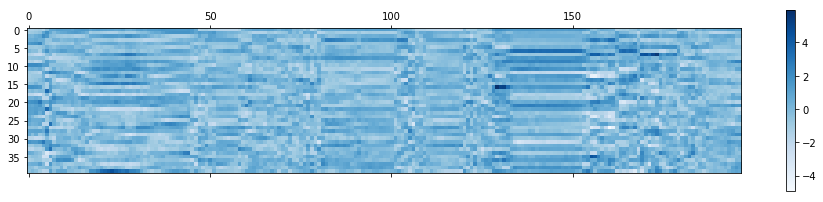

In [30]:
X = np.load('/home/korhan/Desktop/tez/dataset/features/deep_hand_PCA40/c3/right/train/01April_2010_Thursday_heute_default-8.npy')
print(X.shape, X.mean())
plt.matshow(X.T,cmap='Blues')
plt.colorbar()

(4000,) 0.05905286132204725


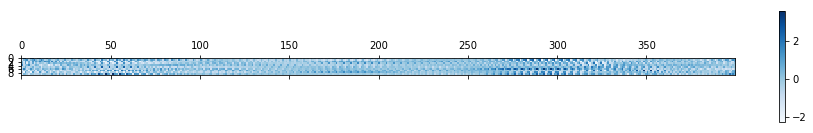

In [31]:
X_emb = embed(X, n=100, r=0.007, s=0.1)
print(X_emb.shape, X_emb.mean())
plt.matshow(X_emb.reshape(d_fix,-1).T,cmap='Blues')
plt.colorbar()

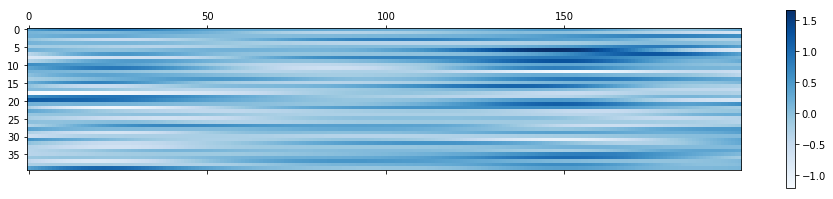

In [138]:
X_emb = embed(X, n=200, r=0.07, s=0.1)
plt.matshow(X_emb.T,cmap='Blues')
plt.colorbar()

### FAISS 

- [x] L2 disinda hangi indexler var
  - inner product var, cosine sim olmasi icin vektorleri l2 normalize et
- id mappingi kendim verebiliyorum
- Faiss reports squared Euclidean (L2) distance

**notes**
- GPU kullanmak overhead olusturur, bi suru query yapilacaksa daha iyi yoksa CPU daha hizli olabilir
- k-means ve PCA de yapilabiliyor
  - dimension 400 falan curse of dim olabilir, o yuzden PCA ile de denemek lazim, 
  - whitening opsiyonu da var, deephand'in raw halini vermek daha mantikli burda
- LSH indexing de var 


**to do**
- [ ] pca indexi dene
- [ ] custom id mapping dene
- [ ] knn indexing'i isolated box yap, in: X --> out: Distances, Ids

In [15]:
import faiss
from faiss import index_factory

In [16]:
index = faiss.IndexFlatL2(d_fix)
index.add(X_index)
index.ntotal

343

In [17]:
k = 40                          # we want to see 4 nearest neighbors
D, I = index.search(X_index[:50], k) # sanity check
print(I)
print(D)

[[ 0  1  2 ... 34 38 42]
 [ 1  2  0 ... 34 38 42]
 [ 2  3  1 ... 34 38 42]
 ...
 [47 48 46 ... 72 68 77]
 [48 47 53 ... 69 78 42]
 [49 50 44 ... 64 19 60]]
[[0.0000000e+00 2.6943848e+01 6.4388306e+01 ... 6.7363702e+02
  6.7493616e+02 7.0117505e+02]
 [0.0000000e+00 2.3000732e+01 2.6943848e+01 ... 6.2102380e+02
  6.2642639e+02 6.4478821e+02]
 [0.0000000e+00 2.1250122e+01 2.3000732e+01 ... 5.5469928e+02
  5.6449139e+02 5.7453943e+02]
 ...
 [4.8828125e-04 1.2688232e+01 1.4778564e+01 ... 2.1264575e+02
  2.3157715e+02 2.3876587e+02]
 [0.0000000e+00 1.2688232e+01 1.8810547e+01 ... 2.2528320e+02
  2.2588672e+02 2.4042700e+02]
 [0.0000000e+00 2.6902344e+01 3.4385864e+01 ... 2.4516968e+02
  2.5457593e+02 2.6674121e+02]]


In [35]:
# pca li nasil oluyor

# random training data 
mt = np.random.rand(1000, 40).astype('float32')
mat = faiss.PCAMatrix(40, 10)
mat.train(mt)
assert mat.is_trained
tr = mat.apply_py(mt)
# print this to show that the magnitude of tr's columns is decreasing
print((tr ** 2).sum(0))

[118.29313  113.21631  110.69804  109.86892  107.127106 105.19928
 103.2987    99.43399   98.97416   96.14391 ]


In [18]:
X = X_index

In [19]:
%%time
# gpu


res = faiss.StandardGpuResources()  # use a single GPU
# build a flat (CPU) index
index_flat = faiss.IndexFlatL2(d_fix)
# make it into a gpu index
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
gpu_index_flat.add(X)

D, I = gpu_index_flat.search(X[:5000], k) 

CPU times: user 344 ms, sys: 232 ms, total: 575 ms
Wall time: 886 ms


In [44]:
# index factory, pca

index = index_factory(d_fix, "PCAW40,Flat")
index.train(X)
index.add(X)
D, I = index.search(X[:50], k)

In [108]:
# inner product & cosine

# cosine uygulancaksa normalizasyon reshape() ten once olmali

faiss.normalize_L2(X)

index = index_factory(d_fix, "PCAW40,Flat", faiss.METRIC_INNER_PRODUCT)
index.train(X)
# index.add(X)
D, I = index.search(X[:50], k)

In [71]:
%%time
class KnnIndex():
    def __init__(self, X, **kwargs):

        
        self.metric_dict = {'L2': faiss.METRIC_L2,
                            'IP': faiss.METRIC_INNER_PRODUCT}
        
        self.metric = kwargs['metric']  # ['L2','IP']
        self.pca = kwargs['pca']        # ['', 'PCA{d}', 'PCAW{d}']
        self.gpu = kwargs['use_gpu']    # [True, False]
        
        self.build_train(X)

        
    def build_train(self, X):
        
        X = X.astype('float32')
        
        if len(X.shape) > 2: X = X.reshape(X.shape[0],-1)        
        N, d_fix = X.shape
        
        if self.metric is 'IP': faiss.normalize_L2(X)
        
        # build a CPU index
        self.index = index_factory(d_fix, 
                                   "{},Flat".format(self.pca), 
                                   self.metric_dict[self.metric])

        if self.gpu:
            res = faiss.StandardGpuResources()  # use a single GPU
            # make it into a gpu index
            self.index = faiss.index_cpu_to_gpu(res, 0, self.index)

        # train index
        if not self.index.is_trained: self.index.train(X)

        
    def search(self, X, k, Xq=None):

        X = X.astype('float32')
        if self.metric is 'IP': faiss.normalize_L2(X)
    
        self.index.add(X)
        
        assert self.index.is_trained
        
        if Xq is None: Xq = X
        # search Xq in index
        D, I = self.index.search(Xq, k)
        
        return D, I

CPU times: user 59 µs, sys: 4 µs, total: 63 µs
Wall time: 70.6 µs


In [91]:
%%time
params = {'pca': 'PCAW20',
          'metric': 'IP',
          'use_gpu': True}

knnindex = KnnIndex(X, **params)


CPU times: user 917 ms, sys: 82.4 ms, total: 999 ms
Wall time: 148 ms


In [92]:
D, I = knnindex.search(X,10)

In [93]:
D

array([[0.6529444 , 0.29204586, 0.13873568, ..., 0.05113855, 0.03667483,
        0.03393216],
       [0.3387267 , 0.29204586, 0.23136367, ..., 0.03379317, 0.03289578,
        0.03161768],
       [0.27280226, 0.23136367, 0.20424928, ..., 0.03331371, 0.03108178,
        0.02767067],
       ...,
       [0.1384625 , 0.13647434, 0.13045187, ..., 0.06638052, 0.04652672,
        0.04341137],
       [0.1518716 , 0.14929575, 0.13647434, ..., 0.06782744, 0.0475156 ,
        0.04335842],
       [0.15692197, 0.1518716 , 0.1384625 , ..., 0.07081197, 0.050641  ,
        0.0439356 ]], dtype=float32)

In [36]:
X = X.astype('float32')

if len(X.shape) > 2: X = X.reshape(X.shape[0],-1)        
N, d_fix = X.shape

In [38]:
N, d_fix

(158, 63)

In [60]:
# build a CPU index
index = index_factory(d_fix, 
                      "PCAW40,Flat", faiss.METRIC_INNER_PRODUCT)


In [61]:
index.is_trained

False

In [55]:
index.train(X)
index.add(X)

In [56]:
D, I = index.search(X[:10], k=10)

In [57]:
D

array([[40.3033  , 39.914444, 39.658897, 39.515953, 39.362617, 39.26544 ,
        39.264534, 38.919273, 38.876312, 38.73844 ],
       [49.626038, 49.139442, 49.12393 , 49.03184 , 48.952568, 48.771008,
        48.740463, 48.6671  , 48.16197 , 48.08286 ],
       [52.514053, 52.25975 , 51.880127, 51.43727 , 51.271584, 50.98481 ,
        50.83908 , 50.639725, 50.52642 , 50.500114],
       [56.8965  , 56.82672 , 56.39865 , 56.031986, 55.853413, 55.56353 ,
        55.545376, 55.46653 , 55.172234, 55.149685],
       [63.244766, 62.951538, 62.57889 , 62.526398, 62.37703 , 61.904816,
        61.789993, 61.58795 , 61.561165, 61.51319 ],
       [59.736435, 58.813652, 58.602993, 58.29642 , 58.053177, 57.99452 ,
        57.668274, 57.66398 , 57.387962, 57.173164],
       [69.72592 , 68.49707 , 67.60896 , 67.43979 , 66.50023 , 66.48285 ,
        66.479164, 65.705215, 65.67769 , 65.509186],
       [60.931694, 59.292664, 59.043686, 57.52407 , 57.223488, 56.853054,
        56.755417, 56.72638 , 56.5846